In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import power_transform, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from paretoset import paretoset
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter


import argparse
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

In [2]:
FOLDER = Path("output/plots/")
csv_file = FOLDER / "data.csv"
data = pd.read_csv(csv_file, index_col=0)
data.columns = data.columns.str.strip()
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data.def_value.replace("", 0, inplace=True)
data.atk_value.replace("", 0, inplace=True)

In [3]:
def plot_aft(
    data,
    file,
    event_col,
    duration_col,
    title,
    mtype,
    xlabel="$\log(\eta)$ - 95% CI",
    ylabel="Covariate",
    replacement_dict={},
    **kwargs,
):
    if mtype == "weibull":
        aft = WeibullAFTFitter(**kwargs)
    elif mtype == "log_normal":
        aft = LogNormalAFTFitter(**kwargs)
    elif mtype == "log_logistic":
        aft = LogLogisticAFTFitter(**kwargs)
    df, test = train_test_split(data, test_size=0.2, random_state=42)
    assert (
        duration_col in df.columns
    ), f"Column {duration_col} not in dataframe with columns {df.columns}"
    assert (
        event_col in df.columns
    ), f"Column {event_col} not in dataframe with columns {df.columns}"
    aft.fit(df, duration_col=duration_col, event_col=event_col)
    ax = aft.plot()
    labels = ax.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k, v in replacement_dict.items():
        labels = [label.replace(k, v) for label in labels]
    ax.set_yticklabels(labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    return ax, aft, test


def clean_data_for_aft(
    data, kwarg_list, standard_scaling=True, target="adv_failure_rate"
):
    subset = data.copy()
    assert target in subset, f"Target {target} not in dataframe with columns {subset.columns}"
    y = subset[target].copy(deep=True)
    cleaned = pd.DataFrame()
    if target in kwarg_list:
        kwarg_list.remove(target)
    for kwarg in kwarg_list:
        cleaned = pd.concat([cleaned, subset[kwarg]], axis=1)
    cols = cleaned.columns
    cleaned.def_value.fillna(0, inplace=True)
    if standard_scaling is True:
        scaler = StandardScaler()
        scaler = scaler.fit(cleaned)
        cleaned_numeric = pd.DataFrame(scaler.transform(cleaned), columns=cols)
    else:
        cleaned_numeric = cleaned

    cleaned_numeric = pd.DataFrame(subset, columns=cols)
    
    cleaned.dropna(inplace=True, how='any',)
    return cleaned_numeric, y

In [30]:
from lifelines.datasets import load_rossi
rossi = load_rossi()
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [59]:
kwarg_list = [
    "accuracy",
    "train_time_per_sample",
    "predict_time_per_sample",
    "atk_value",
    "def_value",
    "data.sample.random_state",
    # "adv_failure_rate",
    "model_layers",
    "adv_fit_time",
    # "adv_accuracy",
]


cleaned, y = clean_data_for_aft(data, kwarg_list, standard_scaling=True)
cleaned.dropna(axis=0, how="any", subset=kwarg_list.remove("def_value"), inplace=True)
cleaned["adv_failure_rate"] = y
cleaned['random_state'] = cleaned['data.sample.random_state']
cleaned.drop(columns=['data.sample.random_state'], inplace=True)
for col in cleaned.columns:
    print(col)


accuracy
train_time
predict_time
atk_value
def_value
model_layers
adv_fit_time
adv_failure_rate
random_state


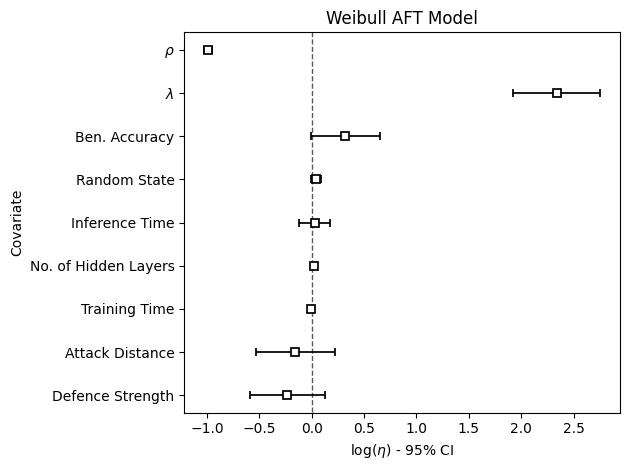

In [60]:
weibull_dict = {
    "Intercept: rho_": "$\\rho$",
    "Intercept: lambda_": "$\lambda$",
    "random_state: lambda_": "Random State",
    "def_value: lambda_": "Defence Strength",
    "atk_value: lambda_": "Attack Distance",
    "train_time: lambda_": "Training Time",
    "predict_time: lambda_": "Inference Time",
    # "adv_accuracy: lambda_": "Adv. Accuracy",
    "accuracy: lambda_": "Ben. Accuracy",
    # "adv_fit_time: lambda_": "Adv. Fit Time",
    "model_layers: lambda_": "No. of Hidden Layers",
}

weibull_graph, wft, wft_test = plot_aft(
    cleaned,
    "weibull_aft.pdf",
    "adv_failure_rate",
    "adv_fit_time",
    "Weibull AFT Model",
    "weibull",
    replacement_dict=weibull_dict,
)

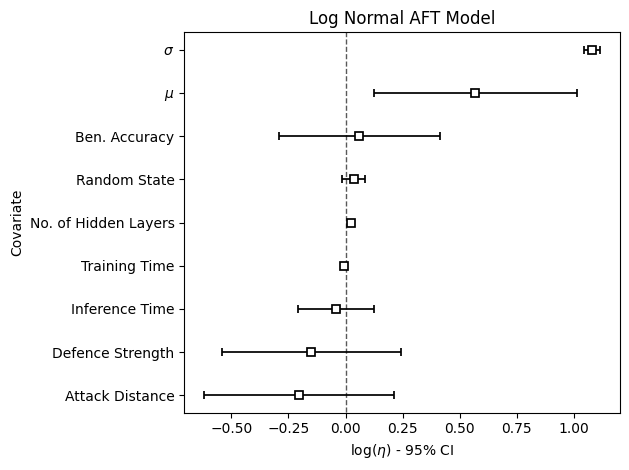

In [62]:
log_normal_dict = {
    "Intercept: sigma_": "$\sigma$",
    "Intercept: mu_": "$\mu$",
    "random_state: mu_": "Random State",
    "def_value: mu_": "Defence Strength",
    "atk_value: mu_": "Attack Distance",
    "train_time: mu_": "Training Time",
    "predict_time: mu_": "Inference Time",
    "accuracy: mu_": "Ben. Accuracy",
    "adv_fit_time: mu_": "Adv. Fit Time",
    "model_layers: mu_": "No. of Hidden Layers",
}

log_normal_graph, lnt, lnt_test = plot_aft(
    cleaned,
    "log_normal_aft.pdf",
    "adv_failure_rate",
    "adv_fit_time",
    "Log Normal AFT Model",
    "log_normal",
    replacement_dict=log_normal_dict,
)

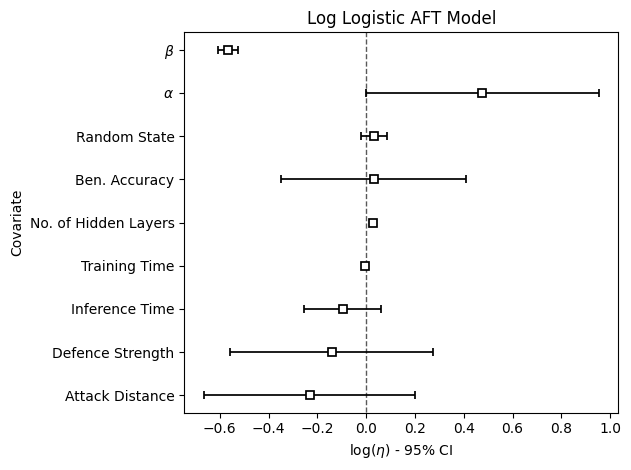

In [63]:
log_logistic_dict = {
    "Intercept: beta_": "$\\beta$",
    "Intercept: alpha_": "$\\alpha$",
    "random_state: alpha_": "Random State",
    "def_value: alpha_": "Defence Strength",
    "atk_value: alpha_": "Attack Distance",
    "train_time: alpha_": "Training Time",
    "predict_time: alpha_": "Inference Time",
    "accuracy: alpha_": "Ben. Accuracy",
    "adv_fit_time: alpha_": "Adv. Fit Time",
    "model_layers: alpha_": "No. of Hidden Layers",
}

log_logistic_graph, llt, llt_test = plot_aft(
    cleaned,
    "log_logistic_aft.pdf",
    "adv_failure_rate",
    "adv_fit_time",
    "Log Logistic AFT Model",
    "log_logistic",
    replacement_dict=log_logistic_dict,
)

In [8]:
aft_dict = {
    "Weibull": wft,
    "LogNormal": lnt,
    "LogLogistic": llt,
}
aft_data = pd.DataFrame()
aft_data.index.name = "Model"
aft_data.index = aft_dict.keys()
aft_data["AIC"] = [x.AIC_ for x in aft_dict.values()]
aft_data["LogLikelihood"] = [x.log_likelihood_ for x in aft_dict.values()]
aft_data["Concordance Score"] = [x.concordance_index_ for x in aft_dict.values()]
aft_data["BIC"] = [x.BIC_ for x in aft_dict.values()]
aft_data = aft_data.round(2)
aft_data.to_csv(FOLDER / "aft_comparison.csv")
logger.info(f"Saved AFT comparison to {FOLDER / 'aft_comparison.csv'}")

In [11]:
wft.log_likelihood_ratio_test()


<lifelines.StatisticalResult: log-likelihood ratio test>
  degrees_freedom = 6
null_distribution = chi squared
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
         324.99 <0.005    220.72

In [21]:
covariates = list(cleaned.columns)
values = cleaned
lnt.plot_partial_effects_on_outcome(covariates, values )

KeyError: 'covariate `adv_fit_time_per_sample` is not present in the original dataset'

In [14]:
llt.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
  degrees_freedom = 6
null_distribution = chi squared
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
         311.17 <0.005    210.88